##Bring in libraries and dataframes and set indexes

In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Read in data
AllData=pd.read_csv('K:\Rainshelter\StonySoilLysimeters\DownloadedData\StonyLysimetersCS650.dat', #specify file path for data to read in
                         parse_dates=True, #tell the function to parse date columns to datetime formats
                         dayfirst=True, #tell the function that the day is before the year in the data i.e format='%d/%m/%Y %H:%M'
                         skiprows = [0,2,3], #leave out rows 1, 3 and 4 which have redundant information
                         index_col = 0, #Use the first column, which is Date, as an index
                         na_values = 'NAN')

#Read in calibration coefficients calculated in C:\GitHubRepos\StonySoilLysimeters\Calibration\CS650Calibration.ipynb
SensorCoefficients = pd.read_pickle('D:\GitHubRepos\StonySoilLysimeters\Calibration\CS650Calibration.pkl')

#Bring in all index data
AllDataIndex=pd.read_csv('D:\GitHubRepos\StonySoilLysimeters\IndexFiles\StonyLysimetersWater&TempIndex.csv',
                         index_col = 0)

#Bring in index for horizion types
HorizonIndex=pd.read_csv('D:\GitHubRepos\StonySoilLysimeters\IndexFiles\HorizonIndex.csv', #specify file path for data to read in
                         index_col = 0, #Use the first column, which is Date, as an index
                         na_values = 'NAN')

#Apply indexes to data
AllDataTransposed = AllData.transpose()
AllDataIndexed = pd.concat([AllDataIndex,AllDataTransposed], axis=1)
AllDataIndexed.index.name='ColumnHeader'
AllDataIndexed.set_index(['Measurement','Depth','Gravels','Stones','Column','Sensor', 'MUX', 'Port','Units','Summary','Block','Treatment'], 
                        append=False, inplace=True)
AllDataIndexed.sort(inplace=True)
Data=AllDataIndexed.transpose()
Data.index = Data.index.to_datetime()  ## for some reason the concat function changes the data type on the date indes so need to change it back

In [3]:
max(Data.index)

Timestamp('2016-03-31 08:30:00')

In [6]:
SensorCoefficients

,Slope,Intercept,LL,DUL
Horizon,,,,
Gravel,0.638859,-0.012200,0.004688,0.120
SubSoil_0,0.971923,0.035146,0.092807,0.320
TopSoil_0,0.950379,0.131111,0.172804,0.350
TopSoil_30,0.886315,0.030407,0.139319,0.245
TopSoil_50,0.487783,0.024764,0.078916,0.175
SubSoil_30,0.906407,0.008151,0.064965,0.224
SubSoil_50,0.498840,0.006638,0.046403,0.160


## Create new data frame and apply calibration coefficients for each horizon type

In [3]:
VWC_uncalibrated = Data.VolumetricWaterContent
VWC_uncalibrated.columns = VWC_uncalibrated.columns.swaplevel('Depth','Sensor') #Make sensor the top level so index selection works properly
VWC_calibrated = pd.DataFrame(index = VWC_uncalibrated.index, columns = VWC_uncalibrated.columns)  #Set up empty dataframe with the same index and column structure as TDR data

for X in range (1,97): 
    SensorRef = 'S_' + np.str(X)
    Horizon = HorizonIndex.ix[X,'Horizon']
    Slope = SensorCoefficients.ix[Horizon,'Slope']
    Intercept = SensorCoefficients.ix[Horizon,'Intercept']
    VWC_calibrated[SensorRef] = VWC_uncalibrated.ix[:,SensorRef] * Slope + Intercept 

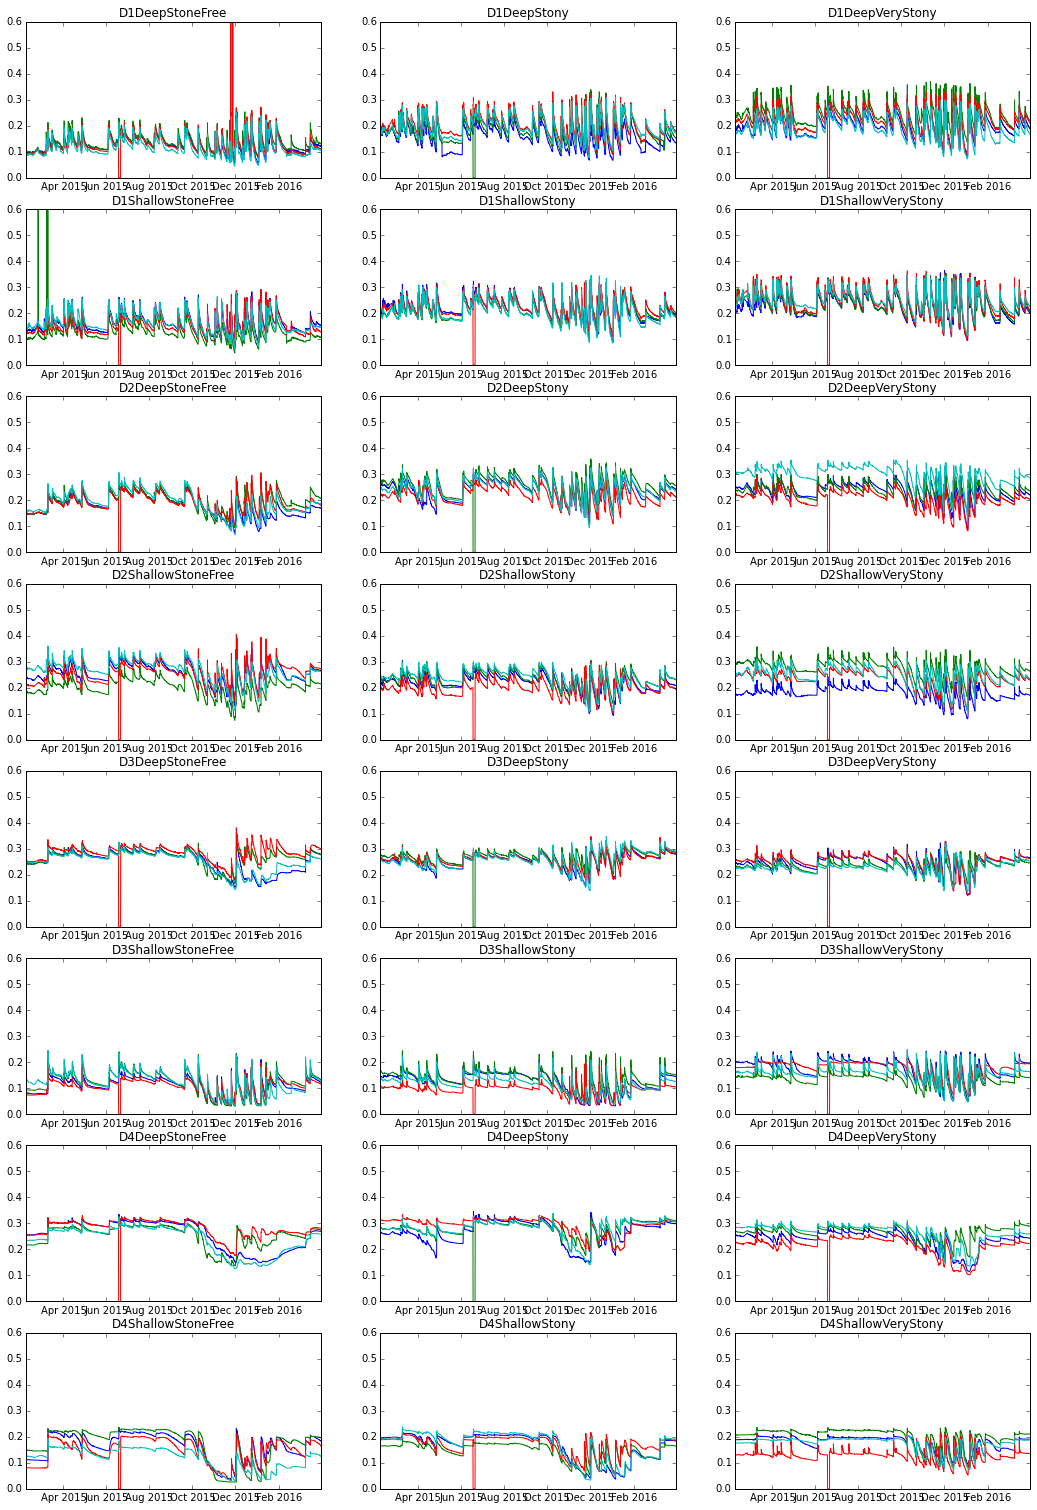

In [4]:
Depths = ['D1','D2','D3','D4']
Gravels = ['Deep','Shallow']
Stones = ['StoneFree','Stony','VeryStony']

Graph = plt.figure(figsize=(18,80))

Pos = 1
for Depth in Depths:    
    for Grav in Gravels:
        for Ston in Stones:
            fig = Graph.add_subplot(24,3,Pos)
            DepthMask = VWC_calibrated.columns.isin([Depth], level='Depth')
            GravelMask = VWC_calibrated.columns.isin([Grav], level='Gravels')
            StoneMask = VWC_calibrated.columns.isin([Ston], level='Stones')
            mask = [all(tup) for tup in zip(DepthMask,GravelMask,StoneMask)]
            plt.plot(VWC_uncalibrated.ix[:,mask].index,
                     VWC_uncalibrated.ix[:,mask],)
            Pos +=1
            plt.ylim(0,0.6)
            plt.title(Depth+Grav+Ston)

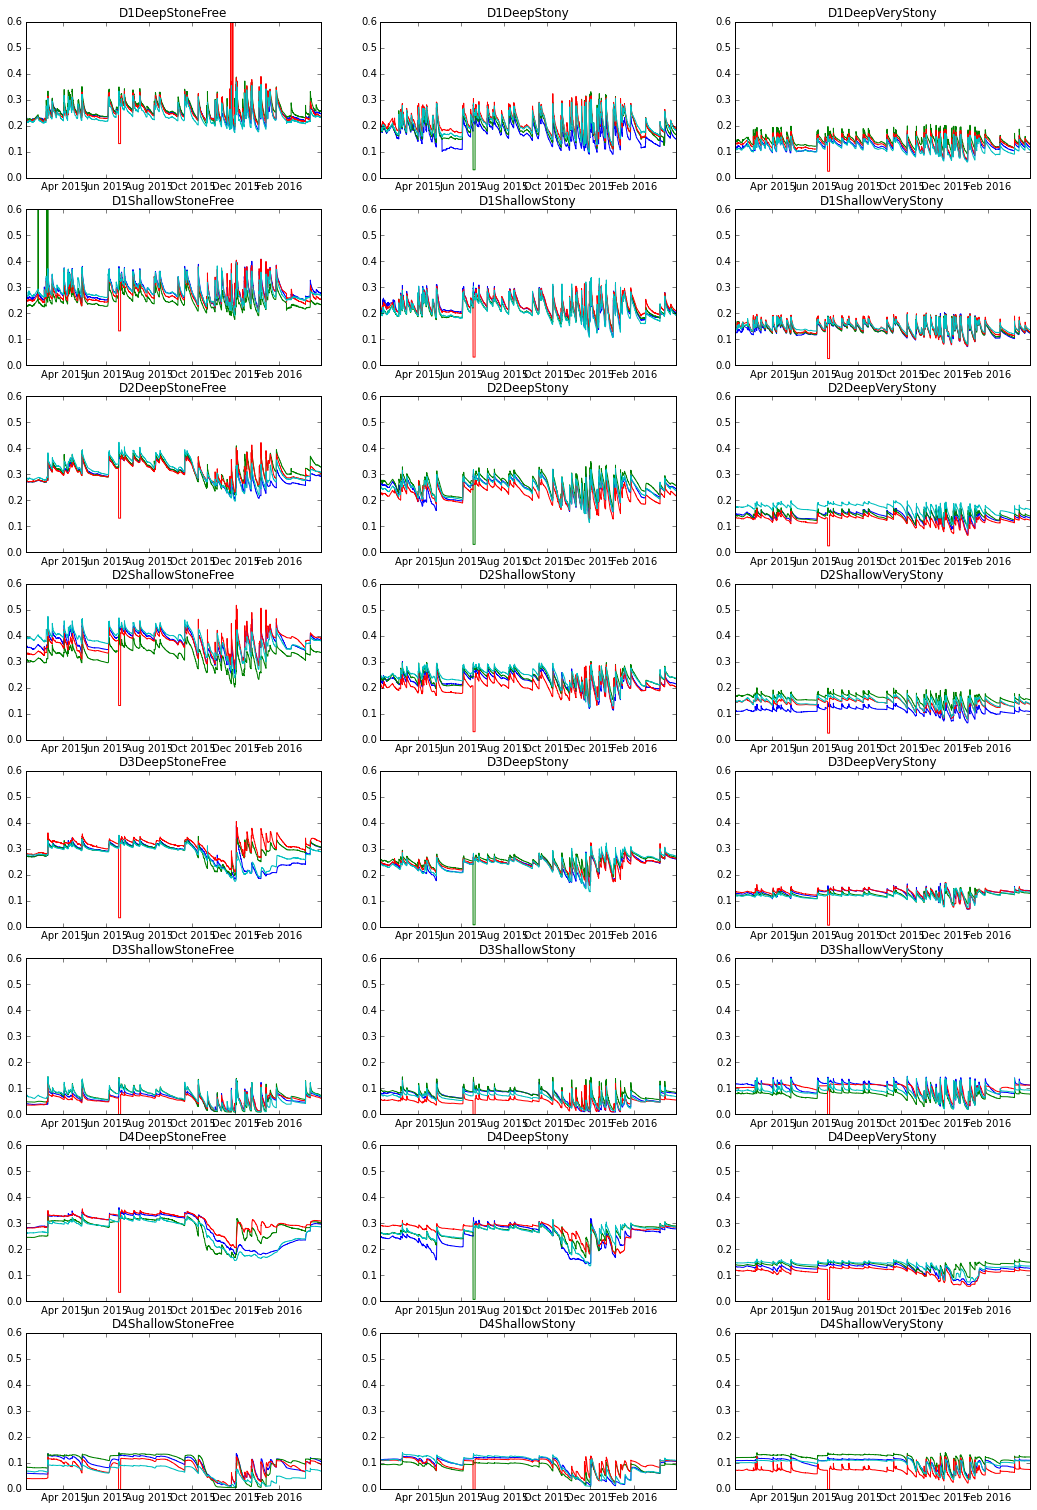

In [5]:
Depths = ['D1','D2','D3','D4']
Gravels = ['Deep','Shallow']
Stones = ['StoneFree','Stony','VeryStony']

Graph = plt.figure(figsize=(18,80))

Pos = 1
for Depth in Depths:    
    for Grav in Gravels:
        for Ston in Stones:
            fig = Graph.add_subplot(24,3,Pos)
            DepthMask = VWC_calibrated.columns.isin([Depth], level='Depth')
            GravelMask = VWC_calibrated.columns.isin([Grav], level='Gravels')
            StoneMask = VWC_calibrated.columns.isin([Ston], level='Stones')
            mask = [all(tup) for tup in zip(DepthMask,GravelMask,StoneMask)]
            plt.plot(VWC_calibrated.ix[:,mask].index,
                     VWC_calibrated.ix[:,mask],)
            Pos +=1
            plt.ylim(0,0.6)
            plt.title(Depth+Grav+Ston)

In [124]:
DepthMask = VWC_calibrated.columns.isin(['D1'], level='Depth')
GravelMask = VWC_calibrated.columns.isin(['Shallow'], level='Gravels')
StoneMask = VWC_calibrated.columns.isin(['VeryStony'], level='Stones')
mask = [all(tup) for tup in zip(DepthMask,GravelMask,StoneMask)]
VWC_uncalibrated.ix[:,mask]

Sensor,S_1,S_69,S_81,S_33
Gravels,Shallow,Shallow,Shallow,Shallow
Stones,VeryStony,VeryStony,VeryStony,VeryStony
Column,1,18,21,9
Depth,D1,D1,D1,D1
MUX,1,3,4,2
Port,1,21,9,9
Units,mm3/mm3,mm3/mm3,mm3/mm3,mm3/mm3
Summary,Samp,Samp,Samp,Samp
Block,1,3,4,2
Treatment,F,F,F,F


##Remove eronius data

(0, 0.5)

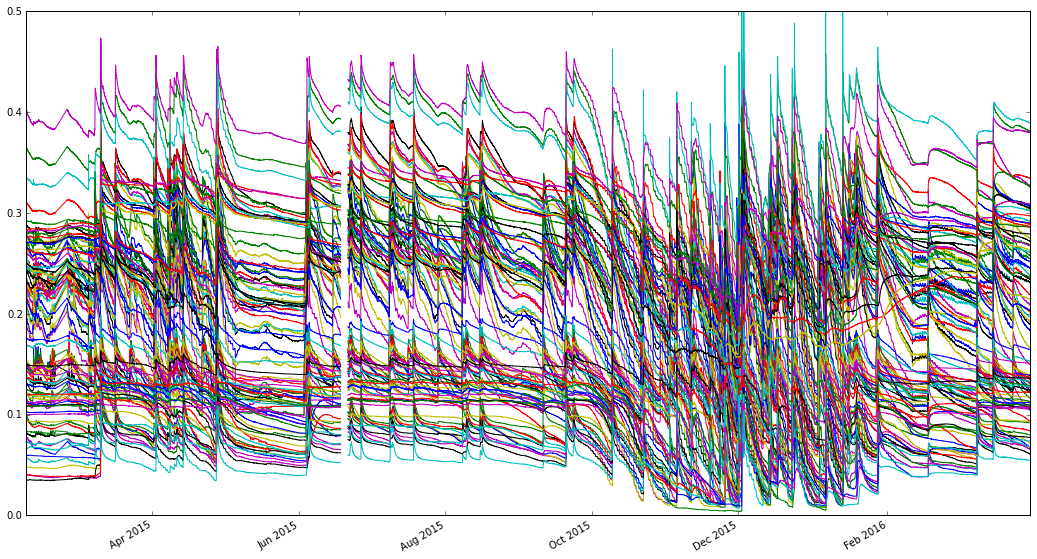

In [135]:
VWC_calibrated.where(VWC_calibrated<0.6,np.nan,inplace=True)
VWC_calibrated.ix['2015-06-18 11:45':'2015-06-21 12:15',:] = np.nan
VWC_calibrated.plot(figsize=(18,10),legend=False)
plt.ylim(0,0.5)

###Calculate Treatment Means

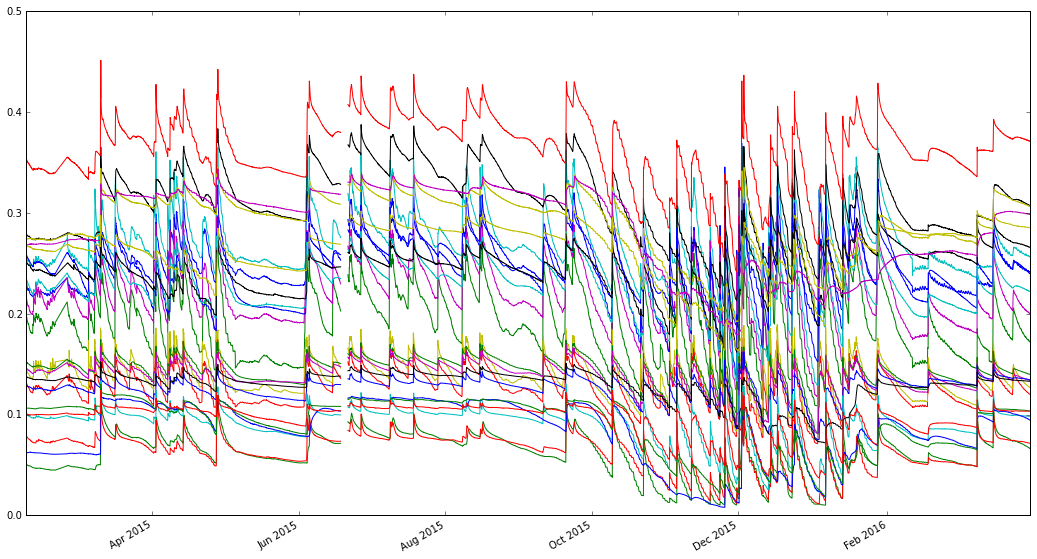

In [136]:
VWCTreatMeans = VWC_calibrated.groupby(level=['Depth','Gravels','Stones'],axis=1).mean()
VWCTreatMeans.plot(figsize=(18,10),legend=False)

###Calculate offsets and plot

In [137]:
#Set up empty dataframe with the same index and column structure as the data object
OffSets = pd.DataFrame(index = VWC_calibrated.index, columns = VWC_calibrated.columns)  

#Step through each series (a series is a time series of measurements for a given depth in a given experimental plot) 
#and produces a sub plot of the time series of VWC data
for X in range (0,96): 
    #Set index values for each series of measurements
    Depth = VWC_calibrated.ix[:,X].name[4]
    Gravels = VWC_calibrated.ix[:,X].name[1]
    Stones = VWC_calibrated.ix[:,X].name[2]
    Block = VWC_calibrated.ix[:,X].name[9]
    DepthMask = VWC_calibrated.columns.isin([Depth], level='Depth')
    GravelMask = VWC_calibrated.columns.isin([Gravels], level='Gravels')
    StoneMask = VWC_calibrated.columns.isin([Stones], level='Stones')
    BlockMask = VWC_calibrated.columns.isin([Block], level='Block')
    mask = [all(tup) for tup in zip(DepthMask,GravelMask,StoneMask,BlockMask)]
    #Create an object containing the time series of mean values for the treatment and depth that the current series belongs to.
    TreatmentMeans = VWCTreatMeans.ix[:,(Depth,Gravels,Stones)]
    #Create an object containing the time series of measurements for the plot and measurement depth currently under consideration 
    SeriesValues = VWC_calibrated.ix[:,mask]
    OffSets.ix[:,mask] = SeriesValues - TreatmentMeans 

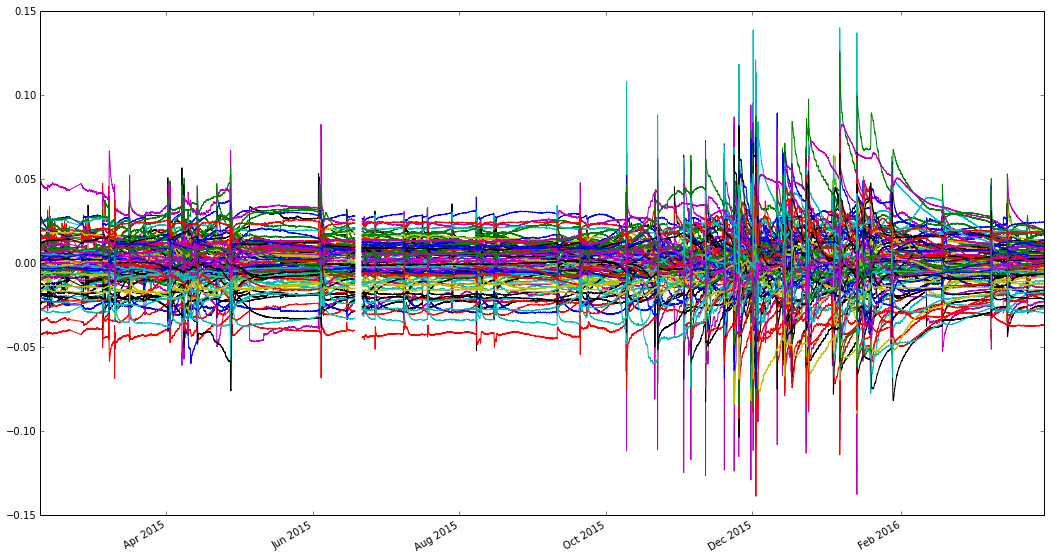

In [138]:
OffSets.plot(figsize=(18,10), legend=False)

##No large spikes suggesting no outlyers that can be easily cleaned

##Calculat plant available water for each horizon

In [139]:
PAW = pd.DataFrame(index = VWC_uncalibrated.index, columns = VWC_uncalibrated.columns)  #Set up empty dataframe with the same index and column structure as TDR data

for X in range (1,97): 
    SensorRef = 'S_' + np.str(X)
    Horizon = HorizonIndex.ix[X,'Horizon']
    LL = SensorCoefficients.ix[Horizon,'LL']
    PAW[SensorRef] = VWC_calibrated.ix[:,SensorRef] - LL 

PAW.to_pickle('.\DataFrames\LysoPAW_df')

## Export volumetric water content dataframes

In [140]:
VWC = VWC_calibrated
VWC.columns = VWC.columns.swaplevel('Sensor','Depth') # Get index back in the same order as the others
VWC.to_pickle('.\DataFrames\LysoVWC_df')

## Export Temperature data frame

In [141]:
Temp = Data.Temperature
Temp.to_pickle('.\DataFrames\LysoTemp_df')

## Export Electrical Conductivity Data frame

In [142]:
EC = Data.ElectricalConductivity
EC.to_pickle('.\DataFrames\LysoEC_df')

##Export Permittivity Data frame

In [143]:
Perm = Data.Permittivity
Perm.to_pickle('.\DataFrames\LysoPerm_df')

##Export Period Data Frame

In [144]:
Period = Data.Period
Period.to_pickle('.\DataFrames\LysoPeriod_df')

##Export Voltage ratio data

In [145]:
VR = Data.VoltageRatio
VR.to_pickle('.\DataFrames\LysoVR_df')